### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from google images. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(1138)

Now prepare to download the files to our repo

In [4]:
gimage_path = "../data/images/"

Nar

In [5]:
# Nar_folder = "Nar"
# Nar_file = "Nar_photos.txt"
# Nar_path = Path('../data/images/Nar')
# Nar_dest = Nar_path/Nar_folder
# Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [6]:
# Nmi_folder = "Nmi"
# Nmi_file = "Nmi_photos.txt"
# Nmi_path = Path('../data/images/Nmi')
# Nmi_dest = Nmi_path/Nmi_folder
# Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [7]:
# Nfr_folder = "Nfr"
# Nfr_file = "Nfr_photos.txt"
# Nfr_path = Path('../data/images/Nfr')
# Nfr_dest = Nfr_path/Nfr_folder
# Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [8]:
# Nhe_folder = "Nhe"
# Nhe_file = "Nhe_photos.txt"
# Nhe_path = Path('../data/images/Nhe')
# Nhe_dest = Nhe_path/Nhe_folder
# Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [9]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [10]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

Commenting the original code while I mess with the progressive resizing

In [11]:
# gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
#                                          valid_pct = 0.2, ds_tfms = get_transforms(),
#                                         size = 224, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [12]:
transforms = get_transforms(flip_vert = True, max_warp = 0.1, \
                            max_zoom = 1.05, )

In [13]:
data_64 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = transforms,
                                        size = 64, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [ ]:
data_64

In [ ]:
print(data_64.classes)

In [ ]:
data_64.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [14]:
# with 64 sized images
learn_rn34 = cnn_learner(data_64, \
                            models.resnet34, \
                            metrics = error_rate)

In [ ]:
learn_rn34.lr_find()

In [ ]:
learn_rn34.recorder.plot()

In [15]:
learn_rn34.fit_one_cycle(5, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~15% after 5 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.950489,4.043954,0.417582,00:17
1,1.567667,1.865081,0.329670,00:16
2,1.315522,1.220635,0.208791,00:17
3,1.179292,0.559441,0.219780,00:17
4,1.079157,0.406014,0.142857,00:17


In [16]:
learn_rn34.save('stage_1_64_rn34')

In [ ]:
#learn_rn34.load('stage_1_64_rn34')

### Now the progressive augmentation

In [17]:
data_128 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 128, num_workers = 4, \
                                      bs = 64).normalize(imagenet_stats)

In [ ]:
data_128.show_batch(rows = 3, figsize = (6, 6))

In [18]:
learn_rn34.unfreeze()
learn_rn34.data = data_128
learn_rn34.freeze()

In [ ]:
learn_rn34.lr_find()

In [ ]:
learn_rn34.recorder.plot()

In [19]:
learn_rn34.fit_one_cycle(3, max_lr = slice(1e-03, 1e-02)) # 5% after 2 epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.865766,0.755389,0.241758,00:16
1,0.676441,0.153740,0.054945,00:16
2,0.553838,0.188592,0.065934,00:16


In [20]:
learn_rn34.save('stage_2_128_rn34') 

#### 256 images

In [21]:
data_256 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 256, num_workers = 4, \
                                      bs = 32).normalize(imagenet_stats)

In [22]:
learn_rn34.unfreeze()
learn_rn34.data = data_256
learn_rn34.freeze()

In [ ]:
learn_rn34.lr_find()

In [ ]:
learn_rn34.recorder.plot()

In [23]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.517238,0.234369,0.098901,00:14
1,0.426447,0.434929,0.131868,00:14
2,0.420359,0.293466,0.087912,00:14
3,0.343967,0.265100,0.065934,00:14


In [24]:
learn_rn34.save('stage_3_256_rn34')

#### Examine problem areas

In [ ]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

In [25]:
interpretation_34 = ClassificationInterpretation.from_learner(learn_rn34)

losses_34, idxs_34 = interpretation_34.top_losses()

len(data_256.valid_ds) == len(losses_34) == len(idxs_34)

True

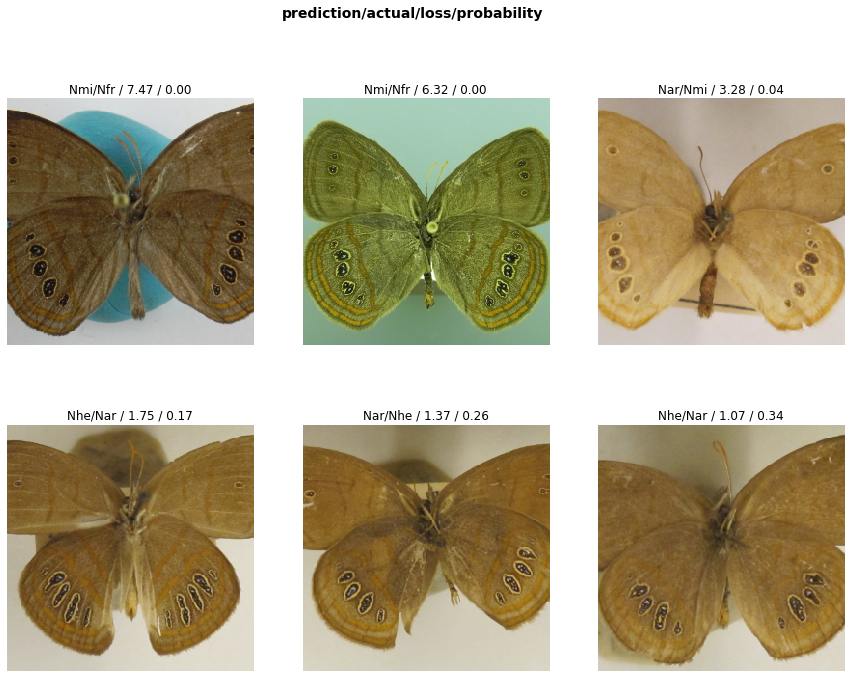

In [26]:
interpretation_34.plot_top_losses(6, figsize = (15, 11))

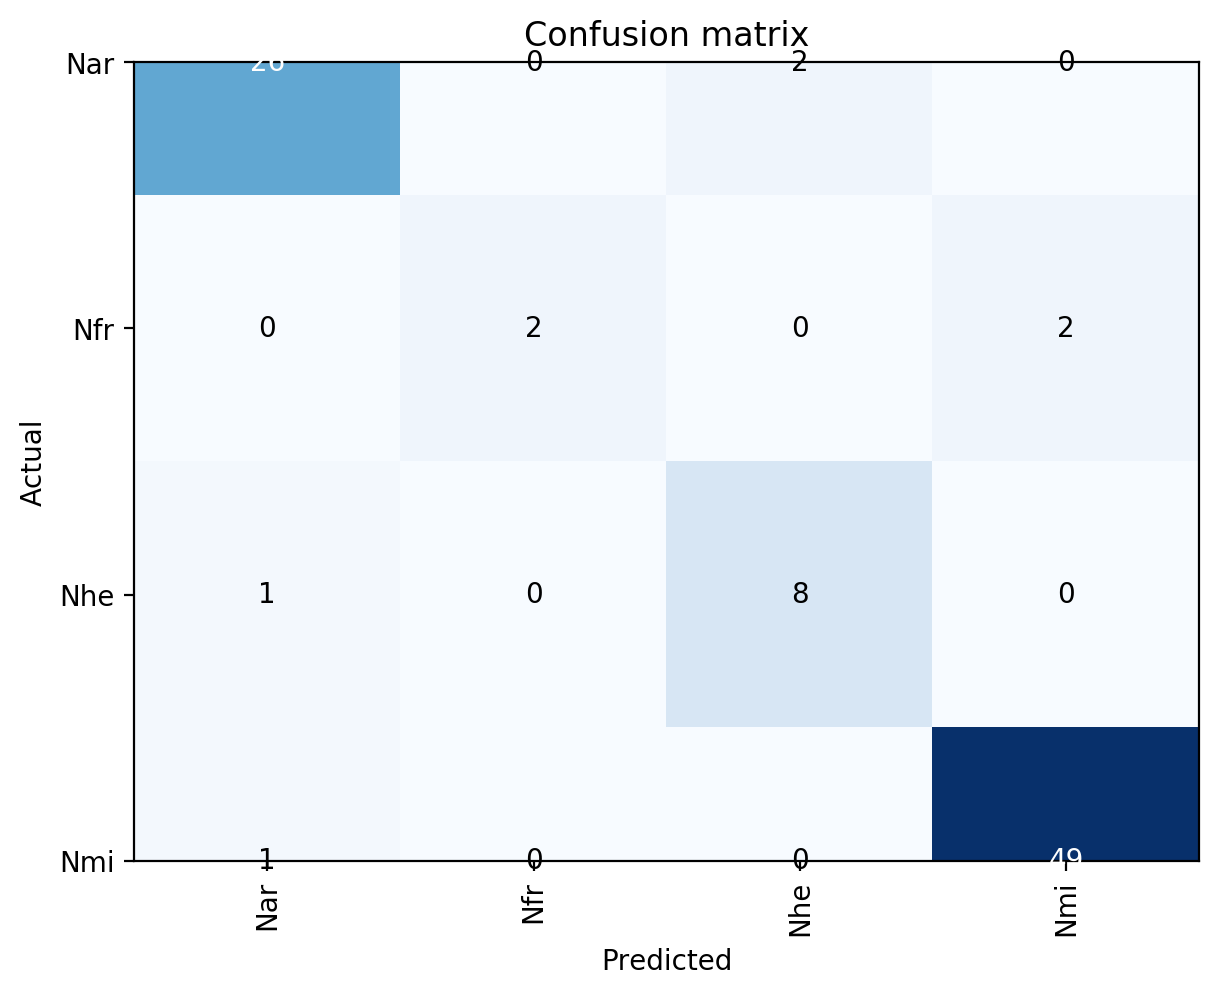

In [27]:
interpretation_34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [28]:
interpretation_34.most_confused(min_val = 0) 

[('Nar', 'Nhe', 2),
 ('Nfr', 'Nmi', 2),
 ('Nhe', 'Nar', 1),
 ('Nmi', 'Nar', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nmi', 0),
 ('Nfr', 'Nar', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

### `resnet50`

Re run the code to generate the `data_64` object. 

In [29]:
# with 64 sized images
learn_rn50 = cnn_learner(data_64, \
                            models.resnet50, \
                            metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


Get the learning rate

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

Use the best LR for the model

In [30]:
learn_rn50.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~15% after 4 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.802874,1.347463,0.263736,00:18
1,1.477315,1.208851,0.274725,00:17
2,1.324788,0.773310,0.164835,00:17
3,1.211749,0.663742,0.175824,00:17


Save the model, fine tune, and save

In [31]:
learn_rn50.save('stage_1_64_rn50')

In [34]:
#learn_rn50.load('stage_1_64_rn50')

Learner(data=ImageDataBunch;

Train: LabelList (365 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images;

Valid: LabelList (91 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Nhe,Nmi,Nmi,Nmi,Nar
Path: ../data/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2)

Now the progressive augmentation

In [35]:
learn_rn50.unfreeze()
learn_rn50.data = data_128
learn_rn50.freeze()

Find the optimal learning rate

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

In [37]:
learn_rn50.fit_one_cycle(2, max_lr = slice(1e-03, 1e-02)) # 9% error

epoch,train_loss,valid_loss,error_rate,time
0,0.392951,0.759034,0.120879,00:18
1,0.317823,0.705440,0.131868,00:17


In [38]:
learn_rn50.save('stage_2_128_rn50')

In [39]:
learn_rn50.unfreeze()
learn_rn50.data = data_256
learn_rn50.freeze()

In [ ]:
learn_rn50.lr_find()

In [ ]:
learn_rn50.recorder.plot()

In [40]:
learn_rn50.fit_one_cycle(4) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.311858,0.450868,0.098901,00:16
1,0.272531,0.327707,0.087912,00:15
2,0.258209,0.224078,0.065934,00:16
3,0.252421,0.232164,0.087912,00:15


In [41]:
learn_rn50.save('stage_3_256_rn50')

### Problem areas

In [42]:
interpretation_50 = ClassificationInterpretation.from_learner(learn_rn50)

losses_50, idxs_50 = interpretation_50.top_losses()

len(data_128.valid_ds) == len(losses_50) == len(idxs_50)

True

In [ ]:
# learn_rn50.load('stage_3_128_rn50')

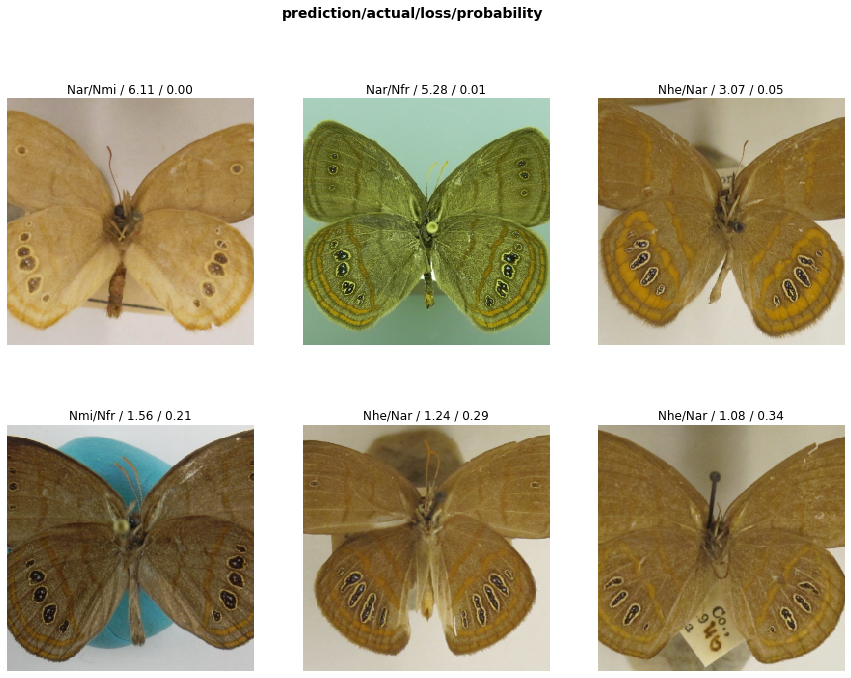

In [43]:
interpretation_50.plot_top_losses(6, figsize = (15, 11))

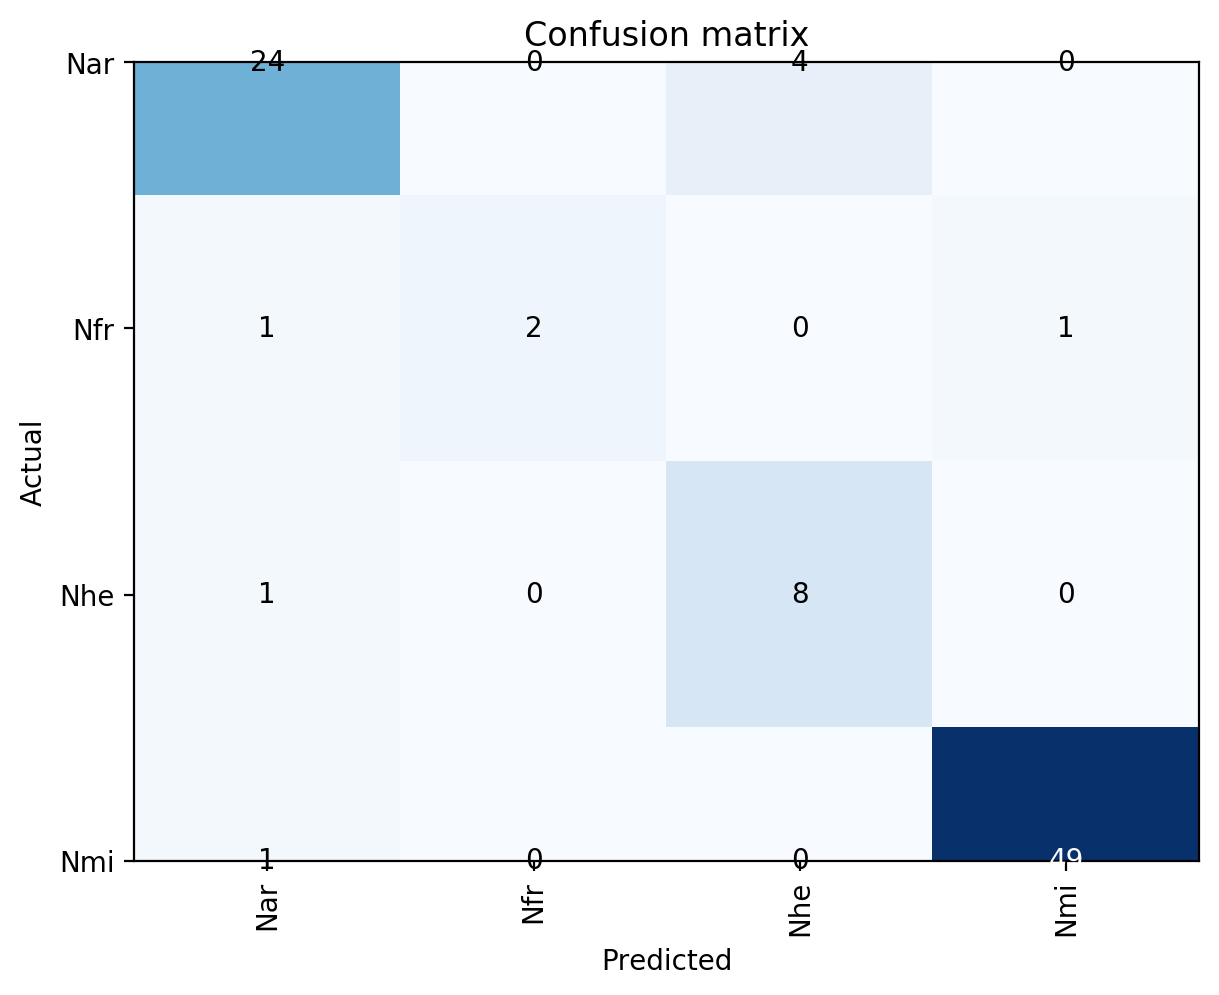

In [44]:
interpretation_50.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [45]:
interpretation_50.most_confused(min_val = 0) # same problems as resnet34.

[('Nar', 'Nhe', 4),
 ('Nfr', 'Nar', 1),
 ('Nfr', 'Nmi', 1),
 ('Nhe', 'Nar', 1),
 ('Nmi', 'Nar', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nmi', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]